In [125]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
class Value:
  def __init__(self , data , _children=(), _op='' , label='') -> None:
    self.data = data
    self._prev = _children
    self._backword = lambda: None
    self._op = _op
    self.grad = 0.0
    self.label = label

  def __add__(self , other)->int:
    other = other if isinstance(other , Value) else Value(other)
    op = Value(self.data + other.data , (self , other) , "+")

    def _backword():
      self.grad += op.grad
      other.grad += op.grad
    op._backword = _backword
    return op

  def __mul__(self , other)->int:
    other = other if isinstance(other , Value) else Value(other)
    op =  Value(self.data * other.data , (self , other) , "*")
    def _backword():
      self.grad += other.data * op.grad
      other.grad += self.data * op.grad
    op._backword = _backword
    return op

  def relu(self):
    op = Value(0 if self.data < 0 else self.data , (self,) , "ReLU")
    def _backword():
      self.grad += (op.data > 0) * op.grad
    op._backword = _backword

  def tanh(self):
    op = Value(math.tanh(self.data) , (self,) , "tanh")
    def _backword():
      self.grad += (1 - op.data**2) * op.grad
    op._backword = _backword
    return op

  def __neg__(self):
    return self * -1

  def __radd__(self , other):
    return self + other

  def __sub__(self , other):
    return self + (-other)

  def __rsub__(self , other):
    return other + (-self)

  def __rmul__(self , other):
    return self * other


  def __truediv__(self , other):
    return self * other**-1

  def __rtruediv__(self , other):
    return other * self**-1

  def __repr__(self) -> str:
    return f"Value({self.data})"

  def __pow__(self , other):
    assert isinstance(other , (int , float))
    op  = Value(self.data**other , (self,) , f"**{other}")
    def _backword():
      self.grad += (other * self.data**(other - 1)) * op.grad
    op._backword = _backword
    return op


  def backword(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backword()

  def __repr__(self) -> str:
    return f"Value({self.data})"


In [9]:
a = Value(3 ); a.label = 'a'
b = Value(-4 ); b.label = 'b'
c = Value(8); c.label = 'c'

In [10]:
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(-4)

In [11]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular node for it
    dot.node(name = uid, label = "{ %s | data %0.4f | %s }" % (n.label, n.data , n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node and connect it to this value
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# # weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# # bias of the neuron
b = Value(6.8813735870195432, label='b')
# # x1*w1 + x2*w2 + b


In [13]:
# forward pass to calculate the output
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [14]:
# backword pass to adjust the gradient
# Gradient of x (x.grad) will tell us that How output should affect when we change x
# Its always important to set the grad to 0 (zero_grad) before running back propagation

# do zero_grad
x1.grad = 0.0
x2.grad = 0.0
w1.grad = 0.0
w2.grad = 0.0
b.grad = 0.0
x1w1.grad = 0.0
x2w2.grad = 0.0
x1w1x2w2.grad = 0.0
n.grad = 0.0
o.grad = 0.0



o.backword()



In [15]:
o.data

0.7071067811865477

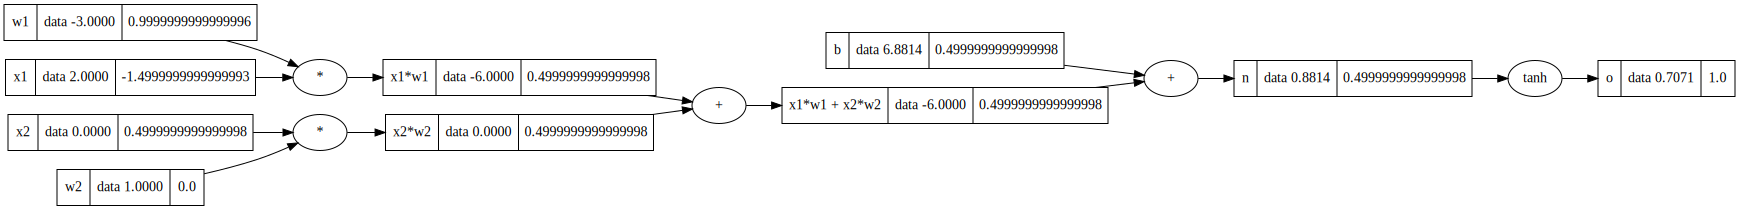

In [16]:
draw_dot(o)

In [17]:
d.grad = 1.0

In [18]:
#  backword --> recompute the gradient

# 1. Call backpropagate on Output node so that
o.grad =1.0


In [19]:
# 1. Call backpropagate on  node o
o._backword()

# 2. Call backpropagate on  node n
n._backword()

# 3. Call backpropagate on  node x1w1x2w2
x1w1x2w2._backword()

# 4. Call backpropagate on  node x1w1

x1w1._backword()

# 5. Call backpropagate on  node x2w2
x2w2._backword()


In [20]:
o.backword()

In [21]:
o.data

0.7071067811865477

In [22]:

import random



class Nueron:

  def __init__(self , nin) -> None:
    self.w = [Value(random.uniform(-1 , 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1 , 1))

  def __call__(self , x):
    act = sum((wi*xi for wi ,xi in zip(self.w , x)) , self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]



class Layer:
  def __init__(self , nin , nout) -> None:
    self.neurons = [Nueron(nin) for _ in range(nout)]

  def __call__(self , x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self , nin , nouts) -> None:
    sz = [nin] + nouts
    # to support #2 , that is sequentially passing output of one layer to input of other layer , we have initialized layers like follows
    '''     dimensions of input matrix     no. of neuron in the layer
       sz = [nin]                       +  nouts

       e.g. Each neuron of dimension 3 in input layer and input layer has 2 neuron

      [3 , 2]

      now further next layer will have input from input layer and so on ....

      [3 , 2, 4 , 4  , 2 , 1 ]

    '''
    self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

  def __call__(self , x):
    for layer in self.layers:
      # 2 here we are basically taking output of one layer and pass to next layer as a input
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [107]:
x = [2 ,1 , -1]
n = MLP(3,  [4 , 4 , 1])



In [108]:
o = n(x)

In [109]:
dataset = [[2 ,1 , -1] ,
           [1 ,3 , -1],
           [1 ,4 , -5],
           [0 , 2 , -1]
           ]


actual = [-1 , 0 ,  1 , 0]



In [112]:
import pandas as pd


In [124]:
# Once we calculate the grad during backword pass
# we know how exactly each parameter is affecting final output
# if grad > 0 --> increasing param will increase the output
# if grad < 0 --> increasing param will decrease the output


# here we want to decrease the loss (output) , so we run 5000 epochs with
epochs = 5000

result = []
loss = 0

for i in range(epochs):
  # forward pass
  result = [n(d) for d in dataset ]
  loss = sum((o - a)**2 for o , a in zip(result , actual))
  print(f"epoch {i} | loss : {loss.data} \n" )

  # backword pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backword()

  # adjust params
  for p in n.parameters():
    p.data += -0.05 * p.grad




print("result:: " ,  result)

Streaming output truncated to the last 5000 lines.

epoch 2501 | loss : 0.00026987503102432074 

epoch 2502 | loss : 0.0002718985954396938 

epoch 2503 | loss : 0.0002697582832231544 

epoch 2504 | loss : 0.0002717805427268004 

epoch 2505 | loss : 0.00026964163303506923 

epoch 2506 | loss : 0.0002716625889888947 

epoch 2507 | loss : 0.0002695250803394065 

epoch 2508 | loss : 0.000271544734103396 

epoch 2509 | loss : 0.00026940862501570055 

epoch 2510 | loss : 0.00027142697794783953 

epoch 2511 | loss : 0.00026929226694367823 

epoch 2512 | loss : 0.00027130932040001046 

epoch 2513 | loss : 0.00026917600600324747 

epoch 2514 | loss : 0.0002711917613378498 

epoch 2515 | loss : 0.00026905984207451937 

epoch 2516 | loss : 0.000271074300639538 

epoch 2517 | loss : 0.0002689437750378218 

epoch 2518 | loss : 0.0002709569381834653 

epoch 2519 | loss : 0.0002688278047736683 

epoch 2520 | loss : 0.0002708396738481954 

epoch 2521 | loss : 0.0002687119311627694 

epoch 2522 | loss 

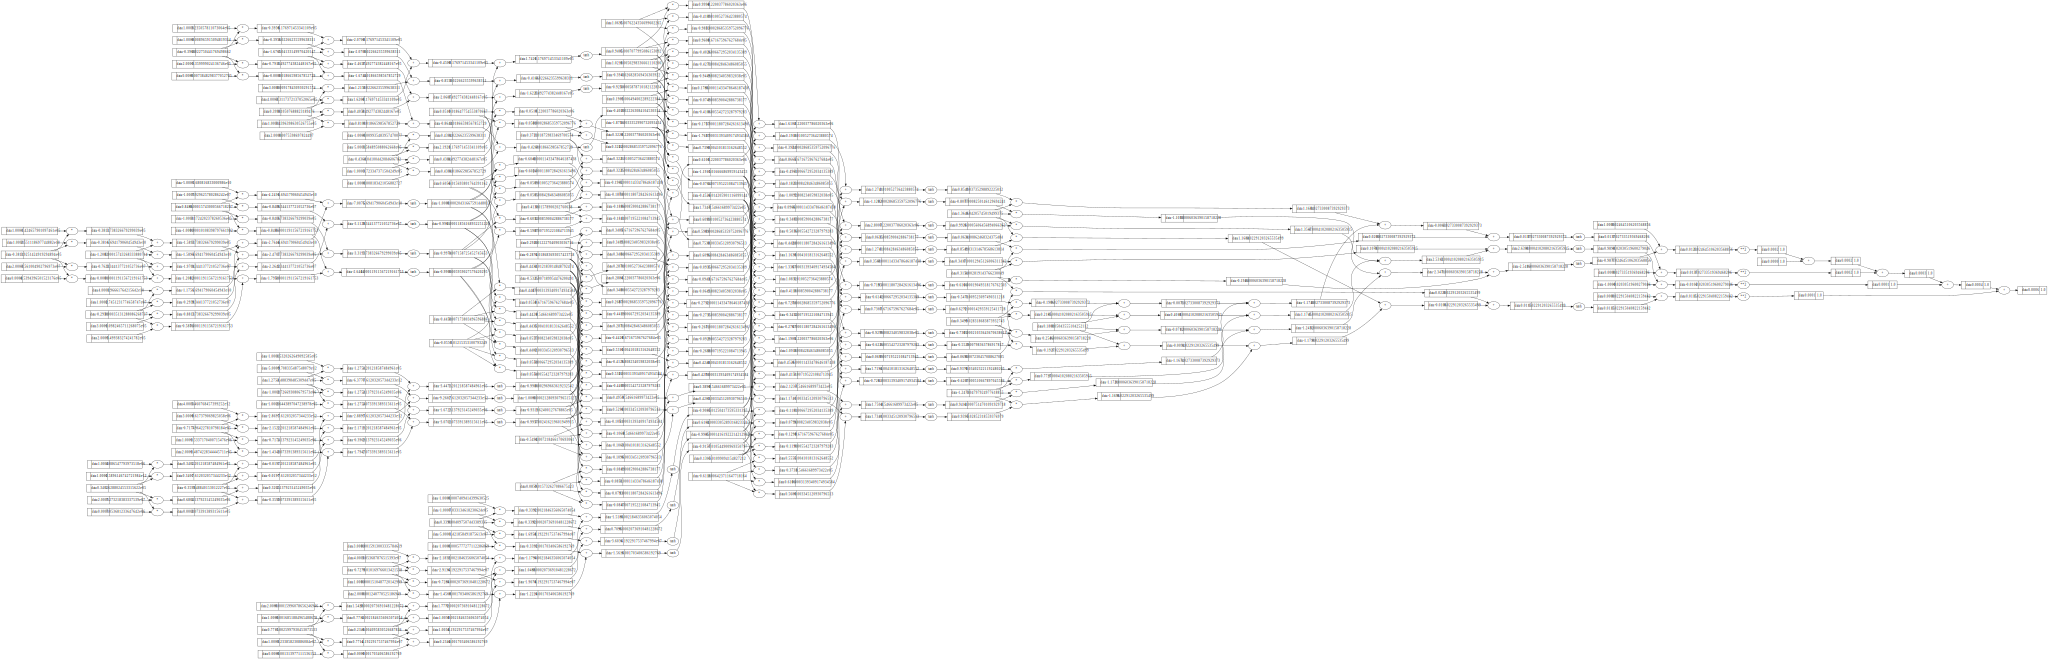

In [123]:
draw_dot(loss)